In [14]:
import argparse
import os
import shutil
import gzip

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch
import torch.nn as nn
from torch.autograd import Variable

from dpp_nets.utils.language import Vocabulary, BeerDataset, custom_collate
from dpp_nets.layers.layers import ChunkTrainer, ChunkTrainerRel

from dpp_nets.utils.language import EvalSet

In [31]:
# Load saved checkpoint
model = 'allwords1reg0.1reg_mean20.0lr0.001marginal_ckp.pth.tar'
model_dir = '/Users/Max/checkpoints/beer_reviews/marginal/' 
model_path = model_dir + model
model = torch.load(model_path, map_location=lambda storage, loc: storage)

In [32]:
from dpp_nets.utils.language import Vocabulary

embd_path = '/Users/Max/data/beer_reviews/review+wiki.filtered.200.txt.gz'
word_path = '/Users/Max/data/beer_reviews/reviews.all.train.words.txt.gz'

# Set-up Vocabulary
vocab = Vocabulary()
vocab.loadPretrained(embd_path)
vocab.setStops()
vocab.loadCorpus(word_path)
vocab.updateEmbedding()
vocab.setCuda(False)
vocab.EmbeddingBag.load_state_dict(model['embedding'])

In [33]:
EMBD_DIM = 200
KERNEL_DIM = 200
HIDDEN_DIM = 500
ENC_DIM = 200
TARGET_DIM = 3 if model['aspect'] in set(['all', 'short']) else 1

if model['mode'] == 'sents':
    trainer = ChunkTrainer(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)
else:
    trainer = ChunkTrainerRel(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)

trainer.load_state_dict(model['model'])
trainer.activation = nn.Sigmoid()
trainer.reg = model['reg']
trainer.reg_mean = model['reg_mean']

rat_path = '/Users/Max/data/beer_reviews/annotations.json'
evalset = EvalSet(rat_path, vocab)

In [34]:
# Plot a table
print('__________________________Training Table__________________________')
for k, v in model['train_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['train_pred_loss'][k][0], model['train_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

__________________________Training Table__________________________
Epoch: 0 | Loss: 0.02511 | Pred Loss: 0.02478 | Reg Loss: 0.00032
Epoch: 1 | Loss: 0.01997 | Pred Loss: 0.01983 | Reg Loss: 0.00014
Epoch: 2 | Loss: 0.01747 | Pred Loss: 0.01734 | Reg Loss: 0.00012
Epoch: 3 | Loss: 0.01518 | Pred Loss: 0.01506 | Reg Loss: 0.00012
Epoch: 4 | Loss: 0.01317 | Pred Loss: 0.01305 | Reg Loss: 0.00012
Epoch: 5 | Loss: 0.01156 | Pred Loss: 0.01143 | Reg Loss: 0.00012
Epoch: 6 | Loss: 0.01035 | Pred Loss: 0.01022 | Reg Loss: 0.00013
Epoch: 7 | Loss: 0.00937 | Pred Loss: 0.00924 | Reg Loss: 0.00013


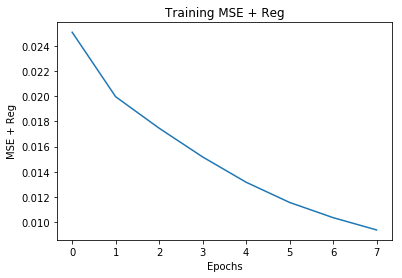

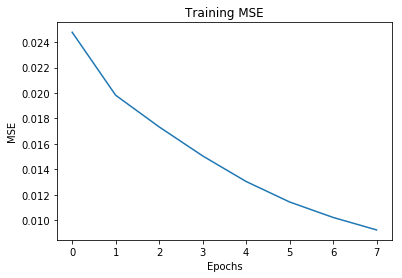

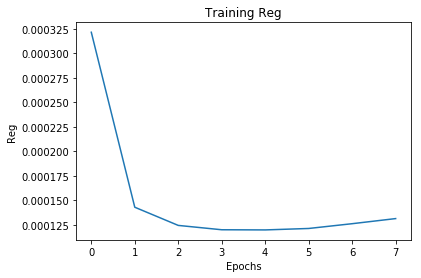

In [35]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['train_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Training MSE + Reg')
plot_floats(model['train_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Training MSE')
plot_floats(model['train_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Training Reg')

In [36]:
print('_________________________Validation Table_________________________')
for k, v in model['val_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['val_pred_loss'][k][0], model['val_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

_________________________Validation Table_________________________
Epoch: 0 | Loss: 0.02213 | Pred Loss: 0.02197 | Reg Loss: 0.00016
Epoch: 1 | Loss: 0.01977 | Pred Loss: 0.01965 | Reg Loss: 0.00013
Epoch: 2 | Loss: 0.01919 | Pred Loss: 0.01907 | Reg Loss: 0.00012
Epoch: 3 | Loss: 0.01814 | Pred Loss: 0.01801 | Reg Loss: 0.00013
Epoch: 4 | Loss: 0.01784 | Pred Loss: 0.01771 | Reg Loss: 0.00012
Epoch: 5 | Loss: 0.01802 | Pred Loss: 0.01790 | Reg Loss: 0.00012
Epoch: 6 | Loss: 0.01810 | Pred Loss: 0.01797 | Reg Loss: 0.00013
Epoch: 7 | Loss: 0.01838 | Pred Loss: 0.01824 | Reg Loss: 0.00014


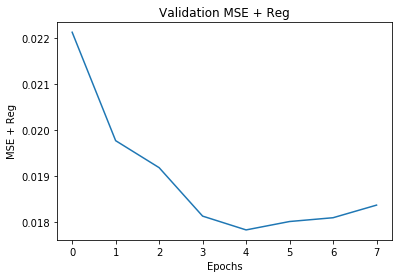

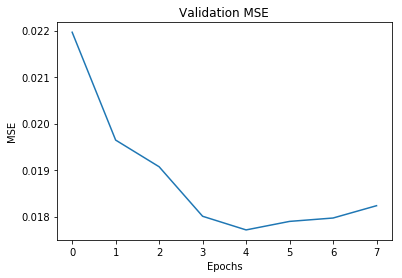

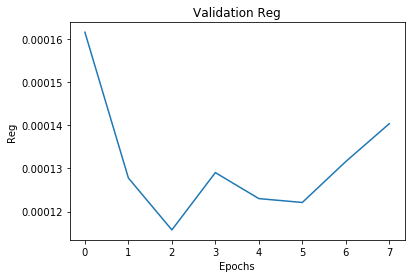

In [37]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['val_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Validation MSE + Reg')
plot_floats(model['val_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Validation MSE')
plot_floats(model['val_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Validation Reg')

In [38]:
# Evaluation on Test Set

loss, pred_loss, reg_loss = evalset.computeLoss(trainer, model['mode'])
print(str.join(" | ", ['Test Set:', 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

prec, extract = evalset.evaluatePrecision(trainer,model['mode'])
print(str.join(" | ", ['Test Set:', 'Precision: %.5f' % (prec), 'Extract: %.5f' % (extract)]))

Test Set: | Loss: 0.01593 | Pred Loss: 0.01576 | Reg Loss: 0.00017
Test Set: | Precision: 0.55801 | Extract: 0.05611


In [52]:
# Random Samples
evalset.sample(trainer, model['mode'],397)

index is: 397
('offset',) {'2'} [('offset',)]
('pear',) set() [('pear',)]
('quickly',) set() [('quickly',)]
('reasonably',) set() [('reasonably',)]
('gamble',) set() [('gamble',)]
('minimal',) {'0'} [('minimal',)]
('thickness',) {'2'} [('thickness',)]
('2003',) set() [('2003',)]
Precision is: 0.375
Extraction Percentage is: 0.05673758865248227
[(I took a gamble on a case of this HSA (as a 2002-2003 the store had it in the discounted out-of-date section)., set()), (It poured A clear dark orangy gold with a minimal head., {'0'}), (The initial aroma was of sharp spices and maple malts., {'1'}), (There's also a touch bitter of hops back there somewhere as well., {'1'}), (The mouthfeel is luscious--a medium thickness offset by modest carbonation., {'2'}), (The taste is reasonably well balanced; there a syrupy cherry and pear sweetness at the start, but it fades quickly as the hops kick in, and the finish is rather tart., set()), (The alcohol is more evident in the taste than I expected for 

In [40]:
# Random Marginals
evalset.computeMarginals(trainer, model['mode'],397)

index is: 397
0 0.689588380926 ('quickly',)
1 0.653810403249 ('minimal',)
2 0.648076841411 ('offset',)
3 0.468730470572 ('gamble',)
4 0.430162234544 ('pear',)
5 0.376120786328 ('2003',)
6 0.347966998184 ('somewhere',)
7 0.337243800531 ('luscious',)
8 0.303984902245 ('reasonably',)
9 0.291223038697 ('case',)
10 0.291107818276 ('syrupy',)
11 0.288289870884 ('alcohol',)
12 0.272540379687 ('modest',)
13 0.270969723179 ('thickness',)
14 0.270035017843 ('orangy',)
15 0.261938974868 ('discounted',)
16 0.248598379567 ('potent',)
17 0.237801472025 ('medium',)
18 0.237635990819 ('date',)
19 0.236900014213 ('sharp',)
20 0.236160564087 ('balanced',)
21 0.236054431232 ('rather',)
22 0.228519950954 ('--',)
23 0.216366852463 ('tart',)
24 0.212360534707 ('section',)
25 0.211306662211 ('store',)
26 0.193404521472 ('reported',)
27 0.184584092533 ('kick',)
28 0.164872252734 ('spices',)
29 0.160297764494 ('touch',)
30 0.157727795673 ('carbonation',)
31 0.156966625499 ('back',)
32 0.149092103993 ('aroma',)

In [41]:
evalset.computeMAPPredLoss(trainer, model['mode'])

0.03775319140213261

In [ ]:
myset = set(['a', 'b', 'c', 'd'])